<a href="https://colab.research.google.com/github/Ikbal-hand/UTS-NLP-HEHE/blob/main/TP_ikbal_10222181.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## About the Data file

We would be using full text articles from the ‘Business’ section of CNN. The articles appeared on that page from late March 2020 to early April 2020 and were scraped.

The articles on the ‘Business’ page focus on a few different themes including investing, banking, success, video games, tech, markets etc.

Let’s do some quick exploratory data analysis to get familiar with the data. There are **`301`** articles in total with an average word count of 732 and a standard deviation of 363 words. Here are the first five rows.

In [3]:
!pip install kagglehub gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 7.2 MB/s eta 0:00:00


In [10]:
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/UTS NLP/cnn_data_4_5.csv'
df = pd.read_csv(file_path)
print(df.shape)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(301, 4)


,url,title,body,date
0,https://www.cnn.com/2020/03/23/media/japan-abe...,Japan asked the international media to change ...,"In the new system ""Canton becomes Guangzhou an...",3/24/2020
1,https://www.cnn.com/2020/03/16/perspectives/us...,The United States is still too reliant on oil,Saudi Arabia's decision to open its taps comes...,3/24/2020
2,https://www.cnn.com/2020/03/23/investing/globa...,Global stocks and US futures rise as policymak...,The promise of unlimited support for markets f...,3/24/2020
3,https://www.cnn.com/2020/03/24/economy/china-e...,China is trying to revive its economy without ...,The country where the pandemic began was almos...,3/24/2020
4,https://www.cnn.com/2020/03/24/business/bailou...,Companies that binged on buybacks now seek bai...,"Now, some of the same companies that binged on...",3/24/2020


## Some EDA & self analysis

In terms of the distribution of the word counts, it’s skewed a little positive but overall it’s a pretty normal distribution with the 25th percentile at 473 words and the 75th percentile at 966 words. There are about 4 outliers (1.5x above the 75th percentile) with the longest article having 2.5K words.

In [11]:
## defining all utilty functions - needed for Data cleaning and processing

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
import nltk

# Contraction map
c_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "I would",
    "i'd've": "I would have",
    "i'll": "I will",
    "i'll've": "I will have",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'alls": "you alls",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you you will",
    "you'll've": "you you will have",
    "you're": "you are",
    "you've": "you have"
}

# Compiling the contraction dict
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))

# List of stop words
add_stop = ['said', 'say', '...', 'like', 'cnn', 'ad']
stop_words = ENGLISH_STOP_WORDS.union(add_stop)

# List of punctuation
punc = list(set(string.punctuation))


# Splits words on white spaces (leaves contractions intact) and splits out
# trailing punctuation
def casual_tokenizer(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens


def expandContractions(text, c_re=c_re):
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)


def process_text(text):
    text = casual_tokenizer(text)
    text = [each.lower() for each in text]
    text = [re.sub('[0-9]+', '', each) for each in text]
    text = [expandContractions(each, c_re=c_re) for each in text]
    text = [SnowballStemmer('english').stem(each) for each in text]
    text = [w for w in text if w not in punc]
    text = [w for w in text if w not in stop_words]
    text = [each for each in text if len(each) > 1]
    text = [each for each in text if ' ' not in each]
    return text


def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]


def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)


def whitespace_tokenizer(text):
    pattern = r"(?u)\b\w\w+\b"
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens


# Funtion to remove duplicate words
def unique_words(text):
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist


def word_count(text):
    return len(str(text).split(' '))

In [13]:
# Get the word count
df['word_count'] = df['body'].apply(word_count)
df['word_count'].mean()

np.float64(731.8338870431894)

In [14]:
# Process the text
df['processed_text'] = df['body'].apply(process_text)
df.head()

,url,title,body,date,word_count,processed_text
0,https://www.cnn.com/2020/03/23/media/japan-abe...,Japan asked the international media to change ...,"In the new system ""Canton becomes Guangzhou an...",3/24/2020,1075,"[new, canton, becom, guangzhou, tientsin, beco..."
1,https://www.cnn.com/2020/03/16/perspectives/us...,The United States is still too reliant on oil,Saudi Arabia's decision to open its taps comes...,3/24/2020,623,"[saudi, arabia, decis, open, tap, come, talk, ..."
2,https://www.cnn.com/2020/03/23/investing/globa...,Global stocks and US futures rise as policymak...,The promise of unlimited support for markets f...,3/24/2020,547,"[promis, unlimit, support, market, feder, rese..."
3,https://www.cnn.com/2020/03/24/economy/china-e...,China is trying to revive its economy without ...,The country where the pandemic began was almos...,3/24/2020,1478,"[countri, pandem, began, complet, shut, late, ..."
4,https://www.cnn.com/2020/03/24/business/bailou...,Companies that binged on buybacks now seek bai...,"Now, some of the same companies that binged on...",3/24/2020,1176,"[compani, bing, buyback, line, receiv, taxpaye..."


In [15]:
# Descriptive statistics for word count
df['word_count'].describe()

,word_count
count,301.000000
mean,731.833887
std,363.347371
min,93.000000
25%,473.000000
50%,682.000000
75%,966.000000
max,2502.000000


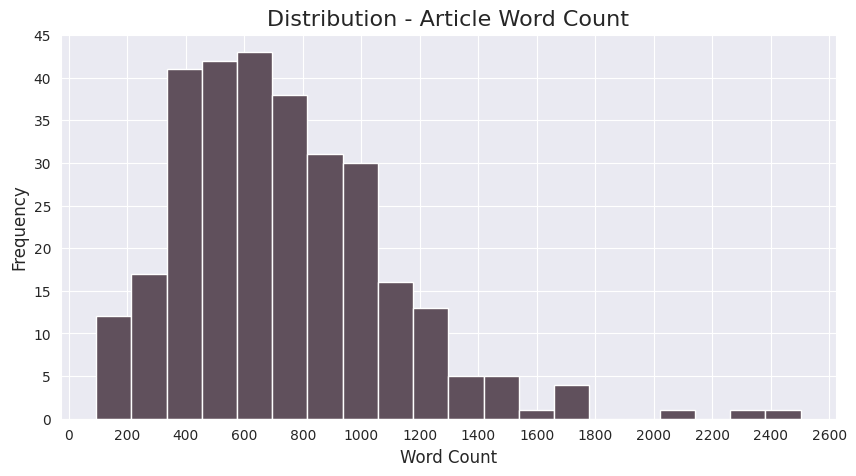

In [16]:
# Plot a hist of the word counts
fig = plt.figure(figsize=(10,5))

plt.hist(
    df['word_count'],
    bins=20,
    color='#60505C'
)

plt.title('Distribution - Article Word Count', fontsize=16)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Word Count', fontsize=12)
plt.yticks(np.arange(0, 50, 5))
plt.xticks(np.arange(0, 2700, 200))


plt.show()

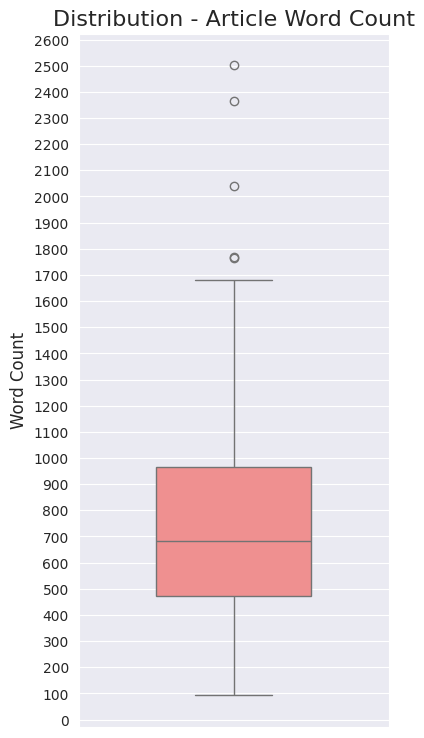

In [17]:
# Plot a boxplot of the word counts
fig = plt.figure(figsize=(4,9))

sns.boxplot(
    df['word_count'],
    orient='v',
    width=.5,
    color='#ff8080'
)

plt.ylabel("Word Count", fontsize=12)
plt.title('Distribution - Article Word Count', fontsize=16)
plt.yticks(np.arange(0, 2700, 100))


plt.show()

Here are the *`top 20 words`* by frequency among all the articles after processing the text. ‘Company’, ‘business’, ‘people’, ‘work’ and ‘coronavirus’ are the top 5 which makes sense given the focus of the page and the time frame for when the data was scraped.

In [18]:
# Get the top 20 most common words among all the articles
p_text = df['processed_text']

# Flaten the list of lists
p_text = [item for sublist in p_text for item in sublist]

# Top 20
top_20 = pd.DataFrame(
    Counter(p_text).most_common(20),
    columns=['word', 'frequency']
)

top_20

,word,frequency
0,compani,972
1,busi,750
2,peopl,718
3,work,693
4,coronavirus,564
5,week,542
6,worker,536
7,time,508
8,year,495
9,new,480


/tmp/ipython-input-2163933584.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(
/tmp/ipython-input-2163933584.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(


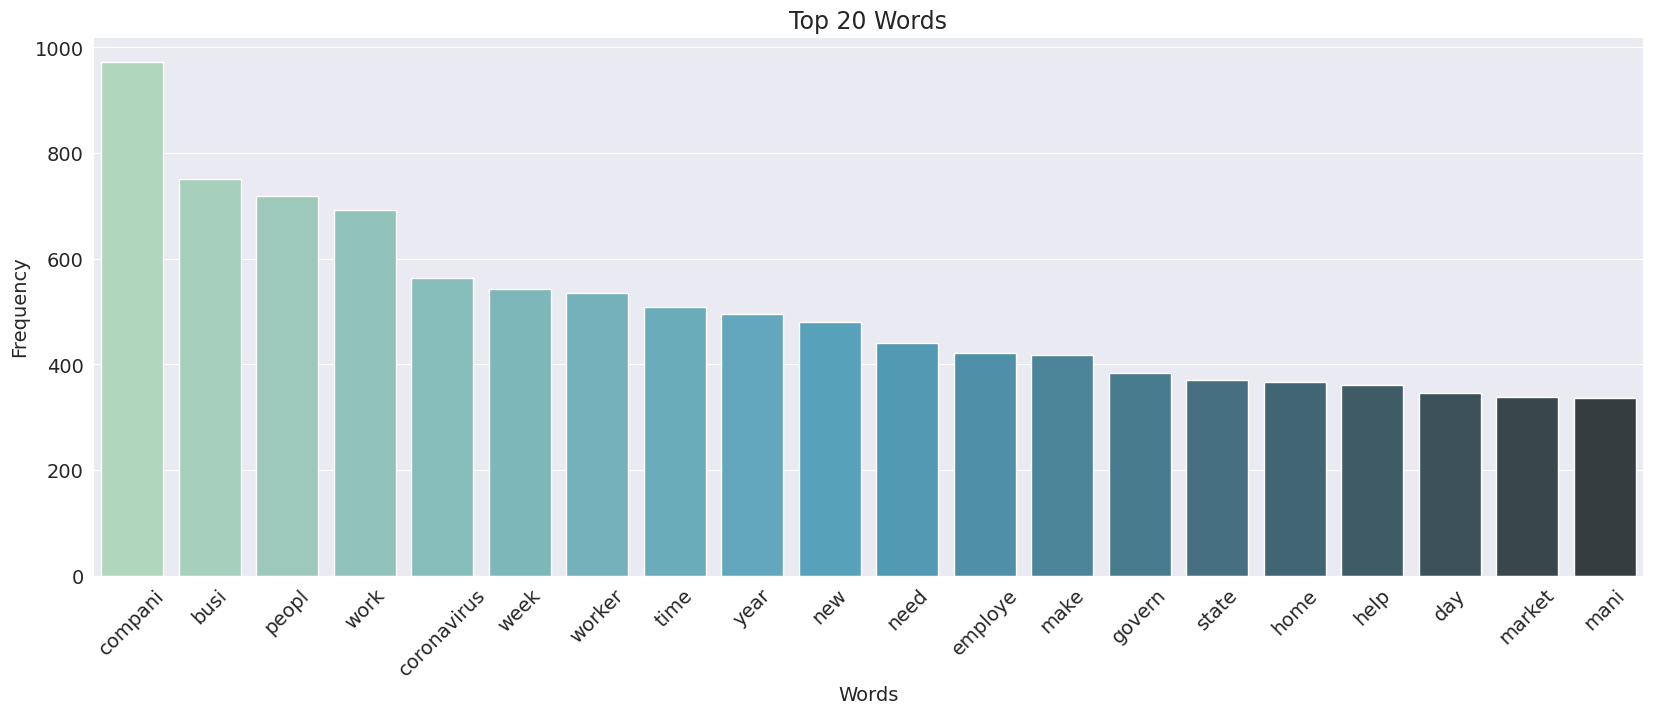

In [19]:
# Plot a bar chart for the top 20 most frequently occuring words
fig = plt.figure(figsize=(20,7))

g = sns.barplot(
    x='word',
    y='frequency',
    data=top_20,
    palette='GnBu_d'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=45,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 20 Words', fontsize=17)


plt.show()

In [ ]:
# Get the number of unique words after processing
num_unique_words = len(set(p_text))
num_unique_words

9127

# NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

Using the original matrix (A), NMF will give you two matrices (W and H). W is the topics it found and H is the coefficients (weights) for those topics. In other words, A is articles by words (original), H is articles by topics and W is topics by words.

So assuming 301 articles, 5000 words and 30 topics we would get the following 3 matrices:

<pre>
A = tfidf_vectorizer.transform(texts)

W = nmf.components_

H = nmf.transform(A)

A = 301 x 5000
W = 30 x 5000
H = 301 x 30
</pre>

**NMF** will modify the initial values of W and H so that the product approaches A until either the approximation error converges or the max iterations are reached.

In our case, the high-dimensional vectors are going to be tf-idf weights.

# Text Processing

This is one of the most crucial steps in the process. As the old adage goes, ‘garbage in, garbage out’. When dealing with text as our features, it’s really critical to try and reduce the number of unique words (i.e. features) since there are going to be a lot. This is our first defense against too many features.

**Note** : You should always go through the text manually though and make sure there’s no errant html or newline characters etc. which can definitely show up and hurt the model.

The utility function defind above (somewhere at the start of this NB) does the following :

> tokenizes the text

> lower cases the text

> expands out contractions

> stems the text

> removes punctuation, stop words, numbers, single characters and words with extra spaces (artifact from expanding out contractions)

## Automatically Selecting the Best Number of Topics

Obviously having a way to automatically select the best number of topics is pretty critical, especially if this is going into production. Using the coherence score we can run the model for different numbers of topics and then use the one with the highest coherence score.


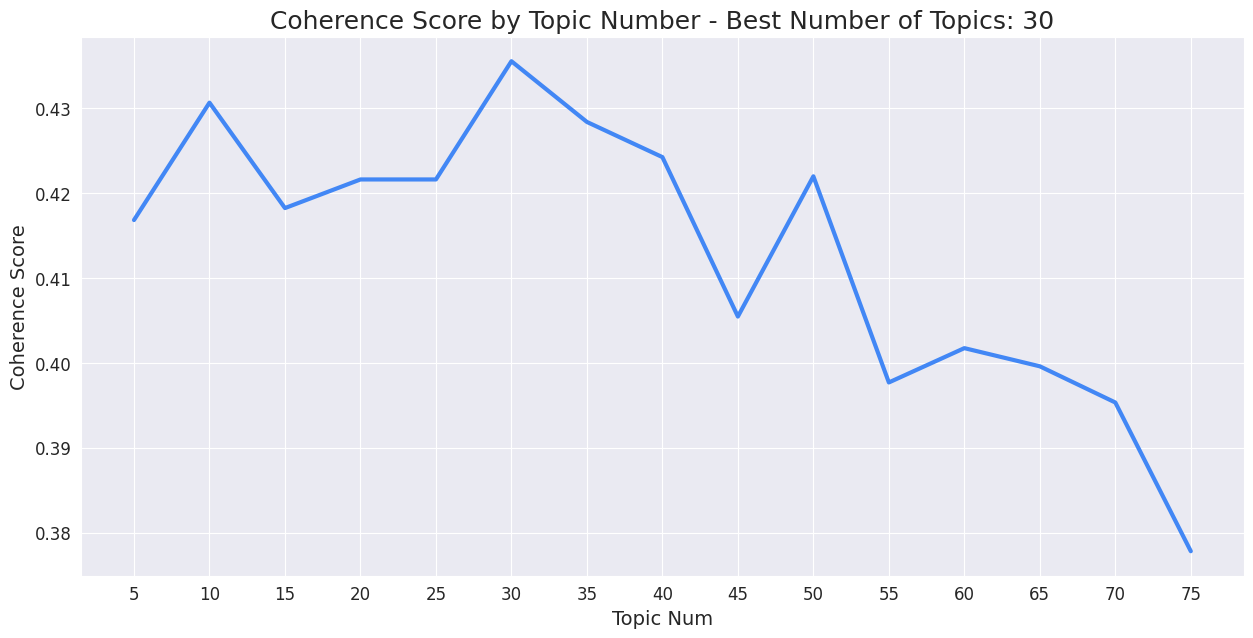

In [20]:
# Use Gensim's NMF to get the best num of topics via coherence score
texts = df['processed_text']

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 75 + 1, 5))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )

    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )

    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

plt.show()

For the number of topics to try out, We chose a range of **`5 to 75`** with a step of 5. This just comes from some trial and error, the number of articles and average length of the articles. Each dataset is different so you’ll have to do a couple manual runs to figure out the range of topic numbers you want to search through. Running too many topics will take a long time, especially if you have a lot of articles so be aware of that.

### In the Above Graph

`30 was the number of topics that returned the highest coherence score (.435) and it drops off pretty fast after that. Overall this is a decent score but I’m not too concerned with the actual value. The real test is going through the topics yourself to make sure they make sense for the articles.`

`10 topics was a close second in terms of coherence score (.432) so you can see that that could have also been selected with a different set of parameters. So, like I said, this isn’t a perfect solution as that’s a pretty wide range but it’s pretty obvious from the graph that topics between 10 to 40 will produce good results. That said, you may want to average the top 5 topic numbers, take the middle topic number in the top 5 etc. For now we’ll just go with 30.`

## Summarizing Topics

Another challenge is summarizing the topics. The best solution here would to have a human go through the texts and manually create topics. This is obviously not ideal. Another option is to use the words in each topic that had the highest score for that topic and them map those back to the feature names. We’ll use top 8 words.

Here’s what that looks like:

In [28]:
# Now use the number of topics with the
# highest coherence score to run the
# sklearn nmf model

texts = df['processed_text']

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)

tfidf = tfidf_vectorizer.fit_transform(texts)

# Save the feature names for later to create topic summaries
tfidf_fn = tfidf_vectorizer.get_feature_names_out()

# Run the nmf model
nmf = NMF(
    n_components=best_num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha_W=0.0,
    tol=1e-4,
    random_state=42
).fit(tfidf)

In [23]:
# Use the top words for each cluster by tfidf weight
# to create 'topics'

# Getting a df with each topic by document
docweights = nmf.transform(tfidf_vectorizer.transform(texts))

n_top_words = 8

topic_df = topic_table(
    nmf,
    tfidf_fn,
    n_top_words
).T

# Cleaning up the top words to create topic summaries
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) # tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

topic_df.head()

,0,1,2,3,4,5,6,7,topics
0,work,home,work home,offic,desk,kid,boss,school,work home offic desk kid boss school
1,oil,saudi,price,arabia,saudi arabia,russia,barrel,opec,oil saudi price arabia russia barrel opec
2,china,economi,econom,economist,quarter,gdp,bank,countri,china economi econom economist quarter gdp ban...
3,trump,fox,news,brief,fox news,hanniti,white hous,presid,trump fox news brief hanniti white hous presid
4,airlin,flight,passeng,carrier,fli,industri,travel,billion,airlin flight passeng carrier fli industri tra...


In [24]:
# Create a df with only the created topics and topic num
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']

topic_df.head()

,topic_num,topics
0,0,work home offic desk kid boss school
1,1,oil saudi price arabia russia barrel opec
2,2,china economi econom economist quarter gdp ban...
3,3,trump fox news brief hanniti white hous presid
4,4,airlin flight passeng carrier fli industri tra...


In [25]:
# Creating a temp df with the url and topic num to join on
url = df['url'].tolist()

df_temp = pd.DataFrame({
    'url': url,
    'topic_num': docweights.argmax(axis=1)
})

# Merging to get the topic num with url
merged_topic = df_temp.merge(
    topic_df,
    on='topic_num',
    how='left'
)

# Merging with the original df
df_topics = pd.merge(
    df,
    merged_topic,
    on='url',
    how='left'
)

df_topics = df_topics.drop(
    'processed_text',
    axis=1
)

df_topics.head()

,url,title,body,date,word_count,topic_num,topics
0,https://www.cnn.com/2020/03/23/media/japan-abe...,Japan asked the international media to change ...,"In the new system ""Canton becomes Guangzhou an...",3/24/2020,1075,22,solar comput technolog spacex energi power veh...
1,https://www.cnn.com/2020/03/16/perspectives/us...,The United States is still too reliant on oil,Saudi Arabia's decision to open its taps comes...,3/24/2020,623,1,oil saudi price arabia russia barrel opec
2,https://www.cnn.com/2020/03/23/investing/globa...,Global stocks and US futures rise as policymak...,The promise of unlimited support for markets f...,3/24/2020,547,16,market dax cac gain futur stock dow kospi
3,https://www.cnn.com/2020/03/24/economy/china-e...,China is trying to revive its economy without ...,The country where the pandemic began was almos...,3/24/2020,1478,2,china economi econom economist quarter gdp ban...
4,https://www.cnn.com/2020/03/24/business/bailou...,Companies that binged on buybacks now seek bai...,"Now, some of the same companies that binged on...",3/24/2020,1176,23,softbank wework fund vision billion startup son


In [26]:
# Showing the 3 matrices we get with nmf
A = tfidf_vectorizer.transform(texts)
W = nmf.components_
H = nmf.transform(A)

print('A = {} x {}'.format(A.shape[0], A.shape[1]))
print('W = {} x {}'.format(W.shape[0], W.shape[1]))
print('H = {} x {}'.format(H.shape[0], H.shape[1]))

A = 301 x 5000
W = 30 x 5000
H = 301 x 30


## Predicting the Topic of New Articles

Once you fit the model, you can pass it a new article and have it predict the topic. You just need to transform the new texts through the tf-idf and NMF models that were previously fitted on the original articles. Notice We’re just calling transform here and not fit or fit transform.

In [37]:
# Predicting the topic for an unseen article

# Load the unseen articles for prediction


file_path = '/content/drive/My Drive/Colab Notebooks/UTS NLP/unseen_cnn_articles.csv'
df_new = pd.read_csv(file_path)
print(df_new.shape)
df_new.head()

# Process the text
df_new['processed_text'] = df_new['body'].apply(process_text)

new_texts = df_new['processed_text']

# Transform the new data with the fitted models
tfidf_new = tfidf_vectorizer.transform(new_texts)
X_new = nmf.transform(tfidf_new)

# Get the top predicted topic
predicted_topics = [np.argsort(each)[::-1][0] for each in X_new]

# Add to the df
df_new['pred_topic_num'] = predicted_topics

df_new

(5, 4)


,url,title,body,date,processed_text,pred_topic_num
0,https://www.cnn.com/2020/02/06/tech/nuro-self-...,US clears the way for this self-driving vehicl...,"Nuro, based in Mountain View, California, is n...",4/11/2020,"[nuro, base, mountain, view, california, abl, ...",22
1,https://www.cnn.com/2020/04/10/success/managin...,How to manage a team remotely during this crisis,"A deadly pandemic, an economic implosion and a...",4/11/2020,"[dead, pandem, econom, implos, new, way, work,...",0
2,https://www.cnn.com/2020/04/13/economy/unemplo...,Congress extended unemployment assistance to g...,"As a freelance copywriter for outdoor, fitness...",4/13/2020,"[freelanc, copywrit, outdoor, fit, brand, spri...",21
3,https://www.cnn.com/2020/04/06/media/federal-r...,Stelter: Federal response to pandemic is a 9/1...,There's a lot of revisionist history being wri...,4/6/2020,"[lot, revisionist, histori, written, right, lo...",3
4,https://www.cnn.com/2020/04/10/tech/nintendo-s...,Nintendo pauses Nintendo Switch shipments to J...,The company confirmed to CNN Business that the...,4/12/2020,"[compani, confirm, busi, new, shipment, ninten...",17
